# Example Feature-Based Cluster Queries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [11]:
import h5py
import math
import numpy as np

In [4]:
chrom = 'chr7'
bin_size = 100000

cluster_tsv_file = '../data/hg19/gm12878_triplets_chr7_100kb_pooled.tsv.gz'
cluster_h5_file = '../data/hg19/gm12878_triplets_chr7_100kb_pooled.h5'

chrom_sizes_file = '../data/hg19/hg19.chrom.sizes'

tads_arrowhead_bed_file = '../data/hg19/Rao_RepH_GM12878_Arrowhead.sorted.bed'
tads_arrowhead_sqlite_file = '../data/hg19/Rao_RepH_GM12878_Arrowhead.sorted.sqlite'

chromhmm_bed_file = '../data/hg19/wgEncodeBroadHmmGm12878HMM.bed.gz'
chromhmm_sqlite_file = '../data/hg19/wgEncodeBroadHmmGm12878HMM.sqlite'

subcompartments_bed_file = '../data/hg19/GSE63525_GM12878_subcompartments.bed.gz'
subcompartments_sqlite_file = '../data/hg19/GSE63525_GM12878_subcompartments.sqlite'

loop_extents_bed_file = '../data/hg19/GSE63525_GM12878_replicate_HiCCUPS_loop_extent_list.bed.gz'
loop_extents_sqlite_file = '../data/hg19/GSE63525_GM12878_replicate_HiCCUPS_loop_extent_list.sqlite'

In [5]:
from hgmc.utils import get_chrom_sizes

chrom_size = get_chrom_sizes(chrom_sizes_file).get(chrom)
num_bins = math.ceil(chrom_size / bin_size)

# Load Features

In [6]:
from hgmc.bed import sql_features
from utils import natural_sort

chromhmm_features = natural_sort(sql_features(chromhmm_sqlite_file))
chromhmm_features

['1_Active_Promoter',
 '2_Weak_Promoter',
 '3_Poised_Promoter',
 '4_Strong_Enhancer',
 '5_Strong_Enhancer',
 '6_Weak_Enhancer',
 '7_Weak_Enhancer',
 '8_Insulator',
 '9_Txn_Transition',
 '10_Txn_Elongation',
 '11_Weak_Txn',
 '12_Repressed',
 '13_Heterochrom/lo',
 '14_Repetitive/CNV',
 '15_Repetitive/CNV']

In [8]:
from hgmc.bed import sql_coverage

tad_coverage_100kb = sql_coverage(
    tads_arrowhead_sqlite_file,
    chrom=chrom,
    bin_size=bin_size,
    # At least 80% of the TAD needs to be in the bin to count
    count_at_feat_cov=0.8,
    rel_count_at_bin_cov=True,
    timeit=True
)
print(f'{tad_coverage_100kb.astype(bool).sum()} bins contain TADs with at most {tad_coverage_100kb.max()} TADs per bin')

active_promoter_coverage_100kb = sql_coverage(
    chromhmm_sqlite_file,
    chrom=chrom,
    bin_size=bin_size,
    features='1_Active_Promoter',
    # The entire promoter needs to be in the bin to count
    count_at_feat_cov=1.0,
    rel_count_at_bin_cov=True,
    timeit=True
)
print(f'{active_promoter_coverage_100kb.astype(bool).sum()} bins contain active promoters with at most {active_promoter_coverage_100kb.max()} active promoters per bin')

strong_enhancer_coverage_100kb = sql_coverage(
    chromhmm_sqlite_file,
    chrom=chrom,
    bin_size=bin_size,
    features=['4_Strong_Enhancer', '5_Strong_Enhancer'],
    # The entire enhancer needs to be in the bin to count
    count_at_feat_cov=1.0,
    rel_count_at_bin_cov=True,
    timeit=True
)
print(f'{strong_enhancer_coverage_100kb.astype(bool).sum()} bins contain enhancers with at most {strong_enhancer_coverage_100kb.max()} enhancers per bin')

a_compartment_coverage_100kb = sql_coverage(
    subcompartments_sqlite_file,
    chrom=chrom,
    bin_size=bin_size,
    features=['A1', 'A2'],
    # At least 80% of the bin need to be an A compartment to count
    count_at_bin_cov=0.8,
    rel_count_at_bin_cov=True,
    timeit=True
)
print(f'{a_compartment_coverage_100kb.astype(bool).sum()} bins are A compartment')

b_compartment_coverage_100kb = sql_coverage(
    subcompartments_sqlite_file,
    chrom=chrom,
    bin_size=bin_size,
    features=['B1', 'B2', 'B3', 'B4'],
    # At least 80% of the bin need to be an A compartment to count
    count_at_bin_cov=0.8,
    rel_count_at_bin_cov=True,
    timeit=True
)
print(f'{b_compartment_coverage_100kb.astype(bool).sum()} bins are B compartment')

loop_extent_coverage_100kb = sql_coverage(
    loop_extents_sqlite_file,
    chrom=chrom,
    bin_size=bin_size,
    # Only count if the entire loop extent is in the bin
    count_at_feat_cov=1.0,
    rel_count_at_bin_cov=True,
    timeit=True
)
print(f'{loop_extent_coverage_100kb.astype(bool).sum()} bins contain loops with at most {loop_extent_coverage_100kb.max()} loops per bin')

Took 0.055 sec
883 bins contain TADs with at most 3 TADs per bin
Took 3.567 sec
400 bins contain active promoters with at most 8 active promoters per bin
Took 4.758 sec
517 bins contain enhancers with at most 38 enhancers per bin
Took 0.068 sec
576 bins are A compartment
Took 0.085 sec
936 bins are B compartment
Took 0.098 sec
1107 bins contain loops with at most 7 loops per bin


In [9]:
all_features = [
    ('TADs', tad_coverage_100kb),
    ('Active Promoters', active_promoter_coverage_100kb),
    ('Strong Enhancers', strong_enhancer_coverage_100kb),
    ('A Compartments', a_compartment_coverage_100kb),
    ('B Compartments', b_compartment_coverage_100kb),
    ('Loops', loop_extent_coverage_100kb),
]

# Queries
#### Find all triplets that anchor in 3 TADs

In [12]:
from hgmc.clusters import query_by_features, verify_queried_clusters

print(f'There are {tad_coverage_100kb.astype(bool).sum()} bins with TADs')

with h5py.File(cluster_h5_file, 'r') as h5:
    query = [(tad_coverage_100kb.astype(bool), 3)]
    tad_cluster_ids = query_by_features(h5, query, verbose=True, verify=True)
    print(f'Found {tad_cluster_ids.size} clusters')

There are 883 bins with TADs
Verify results...
Hooray! The clusters conform to the query.
Found 9052583 clusters


#### Find all triplets that anchor in at least 1 promoter and at least 2 active enhancers

In [13]:
with h5py.File(cluster_h5_file, 'r') as h5:
    query = [
        (active_promoter_coverage_100kb.astype(bool), 1),
        (strong_enhancer_coverage_100kb.astype(bool), 2)
    ]
    promoter_enhancer_cluster_ids = query_by_features(h5, query, verbose=True, verify=True)
    print(f'Found {promoter_enhancer_cluster_ids.size} clusters')

Verify results...
Hooray! The clusters conform to the query.
Found 1040286 clusters


In [15]:
from hgmc.clusters import clusters_to_bins

with h5py.File(cluster_h5_file, 'r') as h5:
    promoter_enhancer_cluster_bins = clusters_to_bins(h5, promoter_enhancer_cluster_ids, timeit=True)
    unique_promoter_enhancer_cluster_bins = np.unique(promoter_enhancer_cluster_bins[:, 1])
    print(f'Found {promoter_enhancer_cluster_bins.shape[0]} bins ({unique_promoter_enhancer_cluster_bins.size} bins)')

Mask generation took 0.2 sec
Cluster start/stop extraction took 0.8 sec
Vrange calculation took 0.0 sec
Cluster-to-bin extraction took 0.6 sec
Bin extraction took 0.1 sec
Total took 1.7 sec
Found 3120858 bins (617 bins)


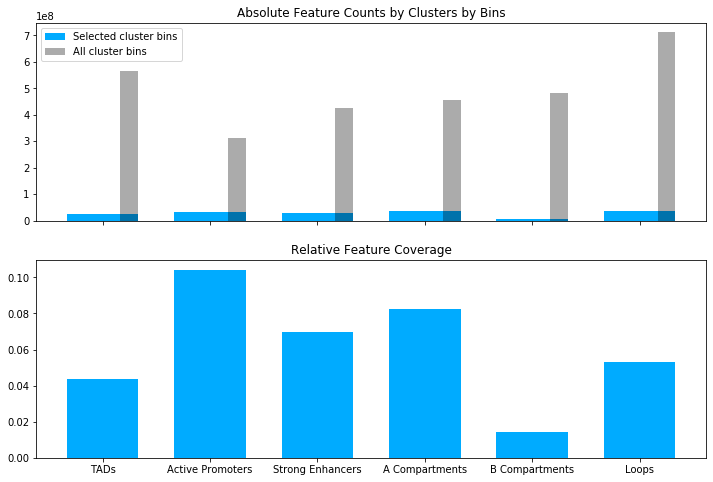

In [16]:
from hgmc.plots import plot_cluster_feature_distribution

with h5py.File(cluster_h5_file, 'r') as h5:
    plot_cluster_feature_distribution(h5, promoter_enhancer_cluster_bins, all_features)